In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
from scipy.ndimage import distance_transform_edt


In [141]:
input_size = 784        #Number of input neurons (image pixels, 28x28)
intervention_size = 11
hidden_size0 = 32
hidden_size1 = 16      #Number of hidden neurons
out_size = 10           #Number of classes (0-9) 
epochs = 10            #How many times we pass our entire dataset into our network 
batch_size = 64        #Input size of the data during one iteration 
learning_rate = 0.001   #How fast we are learning

In [142]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [143]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [197]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size, masks, threshold=0.5):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, intervention_size)
        self.fc1 = nn.Linear(intervention_size, hidden_size0)
        self.fc2 = nn.Linear(hidden_size0, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights()
        
        self.register_buffer('fc0_mask', masks.bool())
        self.threshold = threshold

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #nn.init.constant_(self.fc0.weight, 0.5) nn.init.constant_(self.fc0.bias, 0.0)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

    def apply_fc0_constraints(self):
        with torch.no_grad():
            w = self.fc0.weight.data
            mask = self.fc0_mask

            w[~mask] = 0

            w[mask & (w.abs() < self.threshold)] = (
                self.threshold * w[mask & (w.abs() < self.threshold)].sign()
            )


(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Average Digit 3 (min=0.1 mapped)')

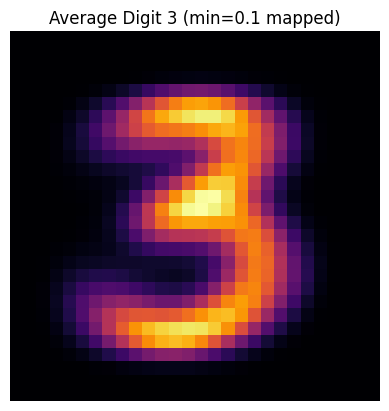

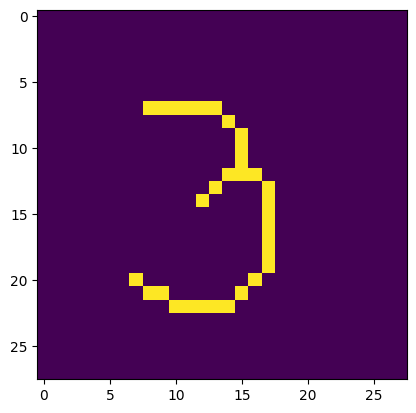

In [ ]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)

target_digit = 3

sum_img = torch.zeros((28, 28))
count = 0

for imgs, labels in trainloader:
    mask = labels == target_digit
    if mask.any():
        selected_imgs = imgs[mask]  #[N, 1, 28, 28]
        sum_img += selected_imgs.sum(dim=0).squeeze(0)
        count += mask.sum().item()

avg_img = sum_img / count

plt.imshow(avg_img, cmap='inferno')
plt.axis('off')
plt.title(f'Average Digit {target_digit} (min=0.1 mapped)')
plt.show()

#print(avg_img)

to_skel = (avg_img > 0.1).float()

skel = skeletonize(to_skel.cpu().numpy())
plt.imshow(skel)

#print(to_skel)

In [161]:
def extract_concepts(skeleton, img):
    img_np = img.cpu().numpy()
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 7
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 3.5).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

In [162]:
tensors, originals = extract_concepts(skeleton=skel, img=avg_img)

In [163]:
ind = 0

<Axes: >

Text(0.5, 1.0, 'Label: 3')

<Axes: >

Text(0.5, 1.0, 'Concept Segment from Original')

(-0.5, 27.5, 27.5, -0.5)

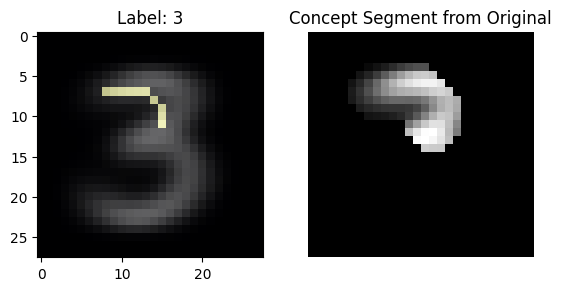

11


In [175]:
plt.subplot(1, 2, 1)
plt.imshow(avg_img.view(28, 28), cmap="gray") #or squeeze()
plt.imshow(tensors[ind].cpu().numpy(), cmap='inferno', alpha=0.6)
plt.title(f"Label: {target_digit}")

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(originals[ind], cmap='gray')

plt.axis('off')
plt.show()
print(len(tensors))

ind = ind + 1 if ind < len(tensors) - 1 else 0

In [176]:
#input: 784 grayscale
#hidden layer 0: 11 neurons
#hidden layer 1: 32 neurons

#masks from 784 to 11:
all_masks = []

for cluster in originals:
    binary_mask = (cluster.view(-1) != 0) #size (784,)
    all_masks.append(binary_mask)

len(all_masks) #11 clusters -> each cluster defines rules for each of the 11 hidden neurons

mask_tensor = torch.stack(all_masks).to(torch.bool)


#constraints for FFN for each cluster-neuron pair:
#weights to neuron that aren't in the binary positive (1) cluster must be 0
#weights from the 1's (the corresponding cluster) must retain a weight >= 0.5, or <= -0.5
#(tanh is used, or should I use ReLU and only allow >= 0.5?, idk which one would make it easier for the net to adapt to the constraints...)

11

In [198]:
CUDA = torch.cuda.is_available()

net = Net(input_size, hidden_size0, hidden_size1, out_size, masks=mask_tensor, threshold=0.5)
if torch.cuda.is_available():
    net = net.cuda()

#The loss function. The Cross Entropy loss comes along with Softmax. Therefore, no need to specify Softmax as well
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


#Training
for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):   
        #(batch,1,28,28)
        images = images.view(-1, 28*28)    
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = net(images)       
        _, predicted = torch.max(outputs.data, 1)                                              
        correct_train += (predicted == labels).sum() 
        loss = criterion(outputs, labels)                 
        running_loss += loss.item()
        optimizer.zero_grad() 
        loss.backward()                                   
        optimizer.step()                             
        net.apply_fc0_constraints()

    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}%'.format
          (epoch+1, epochs, running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset))))
print("DONE TRAINING!")

torch.save(net.state_dict(), f'conceptual_model_0.pth') #'binary_ffn_all.pth')


Epoch [1/10], Training Loss: 1.273, Training Accuracy: 57.925%
Epoch [2/10], Training Loss: 0.830, Training Accuracy: 72.917%
Epoch [3/10], Training Loss: 0.719, Training Accuracy: 76.520%
Epoch [4/10], Training Loss: 0.654, Training Accuracy: 78.892%
Epoch [5/10], Training Loss: 0.612, Training Accuracy: 80.143%
Epoch [6/10], Training Loss: 0.583, Training Accuracy: 81.203%
Epoch [7/10], Training Loss: 0.561, Training Accuracy: 82.002%
Epoch [8/10], Training Loss: 0.545, Training Accuracy: 82.528%
Epoch [9/10], Training Loss: 0.531, Training Accuracy: 82.977%
Epoch [10/10], Training Loss: 0.519, Training Accuracy: 83.433%
DONE TRAINING!


In [158]:

print(torch.sum(abs(net.fc0.weight)) / (784*11))

tensor(0.0975, device='cuda:0', grad_fn=<DivBackward0>)


In [199]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 83.82 %


0: -23.941808700561523
1: -30.238611221313477
2: 30.354738235473633
3: -5.1891984939575195
4: -35.525001525878906
5: 54.6092643737793
6: -3.2947611808776855
7: -19.369285583496094
8: -2.066671848297119
9: 35.24223709106445
10: -31.450942993164062
torch.Size([11])


Text(0.5, 1.0, 'Combined max importasnce of all neurons')

Text(0.5, 1.0, 'Neuron 0\nActivation: 6.331\nWeight: -0.474\nContr. to n5 in l+1: -2.998')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 1\nActivation: 3.122\nWeight: -0.661\nContr. to n5 in l+1: -2.063')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 2\nActivation: -3.13\nWeight: -0.111\nContr. to n5 in l+1: 0.349')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 3\nActivation: -3.575\nWeight: 0.204\nContr. to n5 in l+1: -0.73')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 4\nActivation: 7.79\nWeight: 0.473\nContr. to n5 in l+1: 3.687')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 5\nActivation: 4.721\nWeight: -0.236\nContr. to n5 in l+1: -1.115')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 6\nActivation: -5.559\nWeight: 0.188\nContr. to n5 in l+1: -1.046')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 7\nActivation: 4.316\nWeight: 0.125\nContr. to n5 in l+1: 0.54')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 8\nActivation: -1.979\nWeight: -0.08\nContr. to n5 in l+1: 0.158')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 9\nActivation: 4.092\nWeight: 0.481\nContr. to n5 in l+1: 1.969')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Neuron 10\nActivation: 6.675\nWeight: 0.501\nContr. to n5 in l+1: 3.347')

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 0.98, 'Pixel Importance to all 32 hidden neurons after fc0')

/tmp/ipykernel_30232/1546269989.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


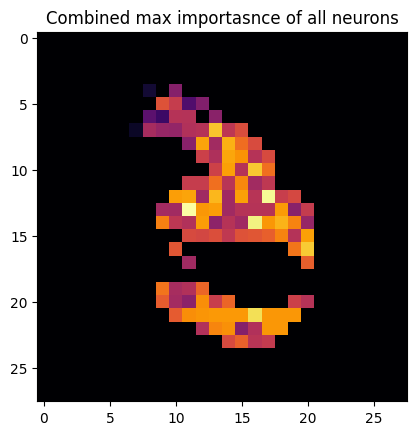

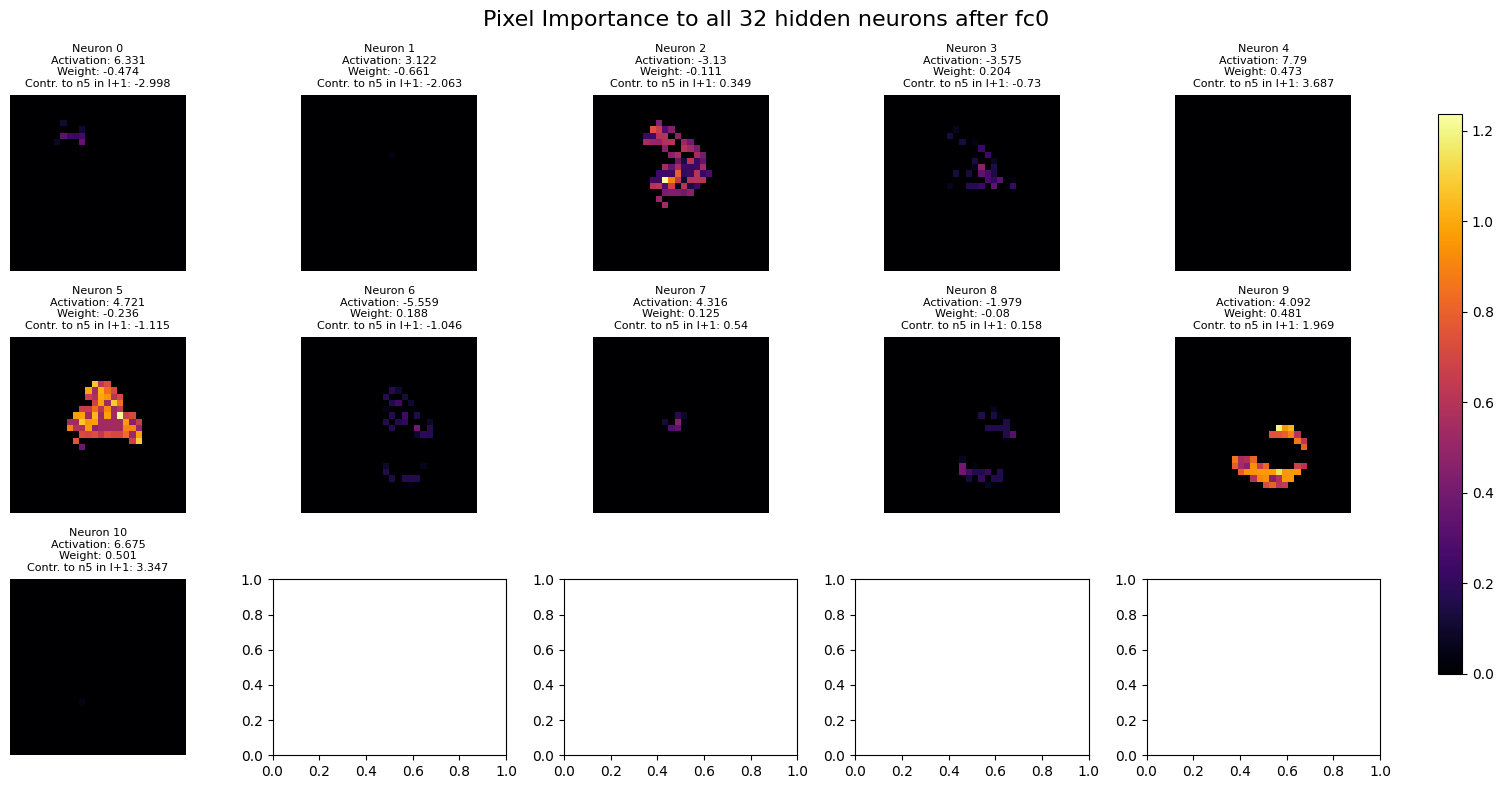

In [202]:
import random as ra

inputs, labels = next(iter(test_loader))
dig_to_check = 3

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break
    
plt.imshow(img, cmap="inferno")

img_flat = img.view(-1)

weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #32, 784

#normalise to [0, 1]
max_val = contribs.max()
contribs_norm = contribs / max_val
contribs_imgs = contribs_norm.view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    1
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #no bias where background = 0

contribs_imgs = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.where(
        contribs_imgs.abs() > 0.0,
        contribs_imgs,
        torch.tensor(0.0, device=contribs_imgs.device)
    )
)

activation_modified = []
for i, mat in enumerate(contribs_imgs):
    mat = mat.sum().item()
    print(f"{i}: {mat}")
    activation_modified.append(mat)


combo = contribs_imgs.max(dim=0).values

activations = net.fc0(img.view(1, -1).cuda()).squeeze()

next_neuron_idx = 5

weights_to_neuron = net.fc1.weight[next_neuron_idx]
contribution = activations * weights_to_neuron

print(weights_to_neuron.size())

plt.imshow(combo, cmap="inferno")
plt.title("Combined max importasnce of all neurons")

fig, axes = plt.subplots(3, 5, figsize=(16, 8))

vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    if i >= 11:
        break
    im = ax.imshow(contribs_imgs[i], cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nWeight: {round(weights_to_neuron[i].item(), 3)}\nContr. to n{next_neuron_idx} in l+1: {round(contribution[i].item(), 3)}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
